In [1]:
# imports and loadings
import sys
sys.path.insert(0, '../functions/')
import create_data_for_single_gene as cdg
import interface_GAMS as iG
import parameter_optimization as po
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

flags = { # add additional settings that should be changed between runs here
    # general flags
    'force_rerun' : False,
    'sanity_plots' : True,
    'central_gene' : 'b1819',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'basal_or_hard_val' : 'basal', # use basal conditions for ratio or some hard value
    'hard_val' : 10, # the basal log tpm value
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest

    # picking KdRNAPCrp values
    'initial_guess_ratio' : .3, # this commonly needs to get raised and lowered to get a good value, eventually I will figure out a way to automate it if this step stays in the pipeline
    'base_cInhibitor_val' : 0.1, # this is the set minimum value to solve cActivator based on to set its dynamic range
    'base_cActivator_val' : 0.1, # defines the range of cInhibitor values available
    
    # cAct & cInh Grid flags
    'auto_set_max_range' : True, # if True, set the range based on the set to zero values of the KdRNAPCrp calculator
    'additional_tolerance' : 0.10, # add this %age of the maximum to the top
    'cActivator' : [-2,2], # Uses a log10 range
    'cInhibitor': [-2,2], # Uses a log10 range
    'run_greedy' : False, # skips greedy algo to save time

    # GA - best cActivator/cInhibitor flags
    'neg_grid_toss_OR_zero' : 'toss', # options: toss or zero, what to do with negative grid values
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 100, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook
    
    # greedy
    'n_iter' : 5, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual

    # GAMs
    'use_greedy' : False, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b1101', 'b1817', 'b1818', 'b1819'], # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    
    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',
}

t_half_life_deg = 300
cell_constants = { # should hold true across all samples, I think...
    'RNAP': 10**-6,
    'mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'promoterConcVal': 10**-9, # Promoter concentration
}


def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"

    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)


In [2]:
# multiprocess run

# setup inputs
gene_flags = []
genes = ['b1101', 'b1817', 'b1818', 'b1819']
for gene in genes:
    temp_flags = flags.copy()
    temp_flags['central_gene'] = gene
    gene_flags.append(temp_flags)

# run pool
pool = multiprocessing.Pool(processes = len(genes))
results = pool.map(cdg.create_data_for_gene, gene_flags)
pool.close()
pool.join()

Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
  File "/home/chris/mambaforge/envs/TRN_model/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/chris/mambaforge/envs/TRN_model/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chris/mambaforge/envs/TRN_model/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/chris/mambaforge/envs/TRN_model/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/chris/github/regulonML/merged_workflow/../functions/create_data_for_single_gene.py", line 79, in create_data_for_gene
    po.create_shared_lambda_df(eq_str, grid_constants)
  File "/home/chris/github/regulonML/merged_workflow/../functions/parameter_optimization.py", line 93, in cre

  File "/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/sympy/solvers/solvers.py", line 1112, in solve
    solution = _solve(f[0], *symbols, **flags)
  File "/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/sympy/solvers/solvers.py", line 1112, in solve
    solution = _solve(f[0], *symbols, **flags)
  File "/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/sympy/physics/units/__init__.py", line 213, in <module>
    from .systems import (
  File "/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/sympy/solvers/solvers.py", line 1473, in _solve
    f_num, sol = solve_linear(f, symbols=symbols)
  File "/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/sympy/solvers/solvers.py", line 1473, in _solve
    f_num, sol = solve_linear(f, symbols=symbols)
  File "/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/sympy/physics/units/systems/__init__.py", line 4, in <module>
    from sympy.physic

KeyboardInterrupt: 

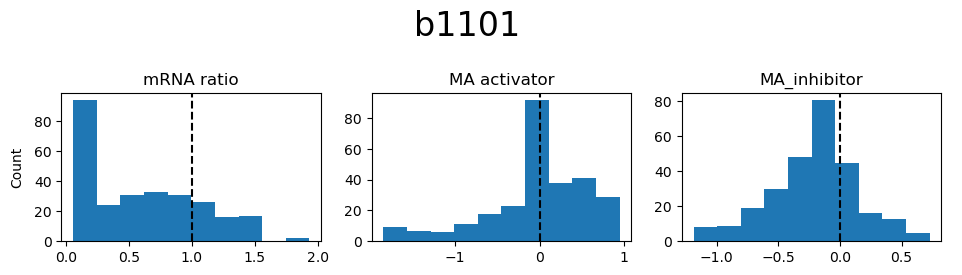

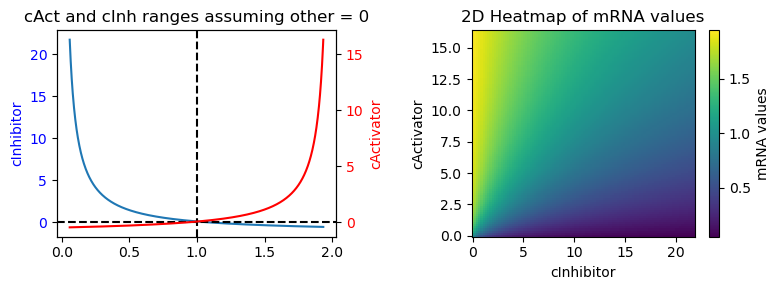

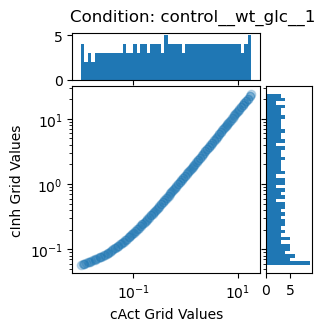

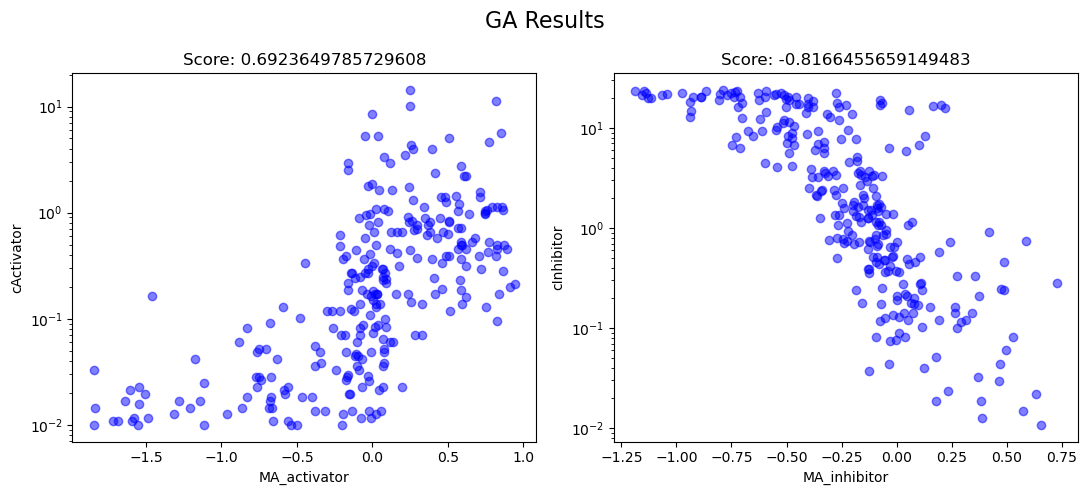

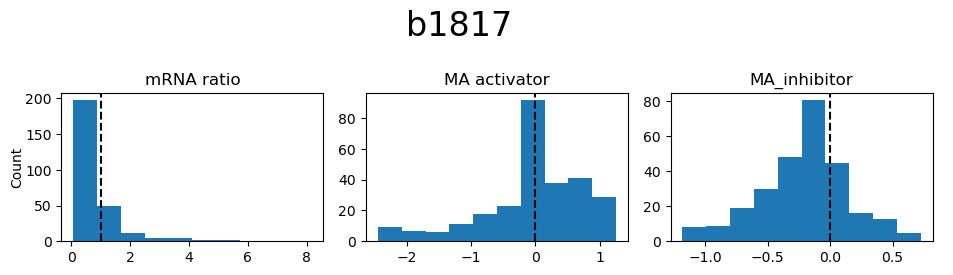

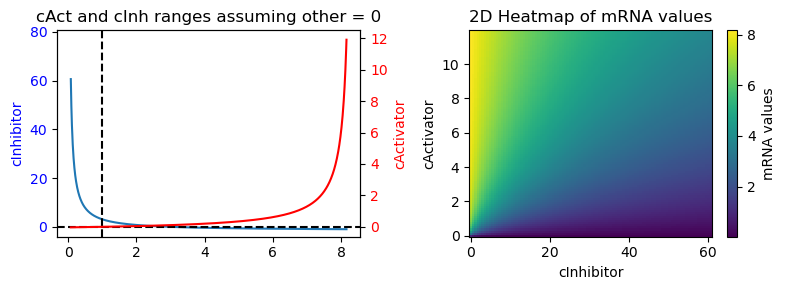

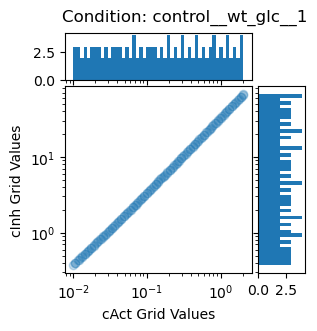

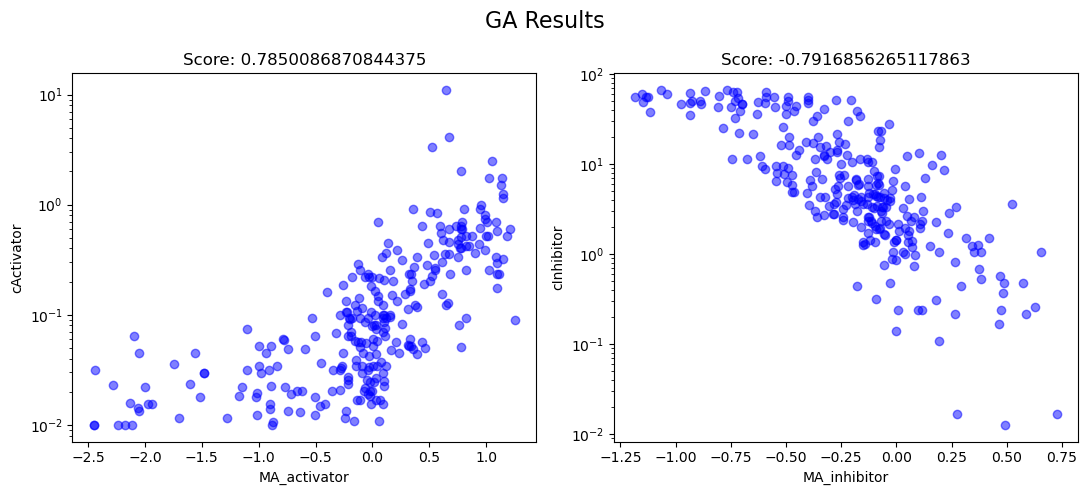

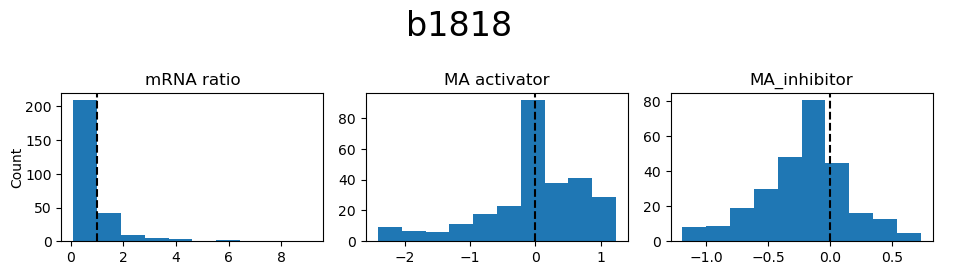

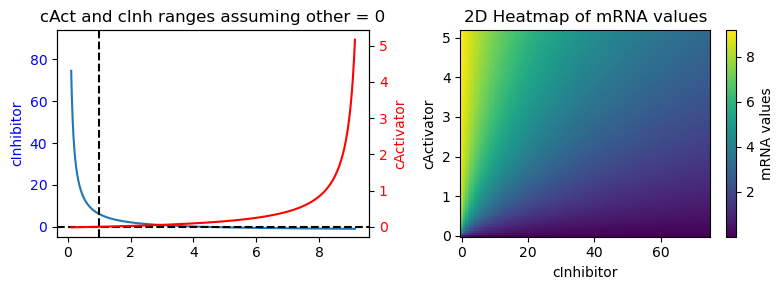

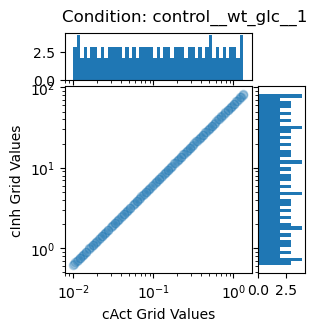

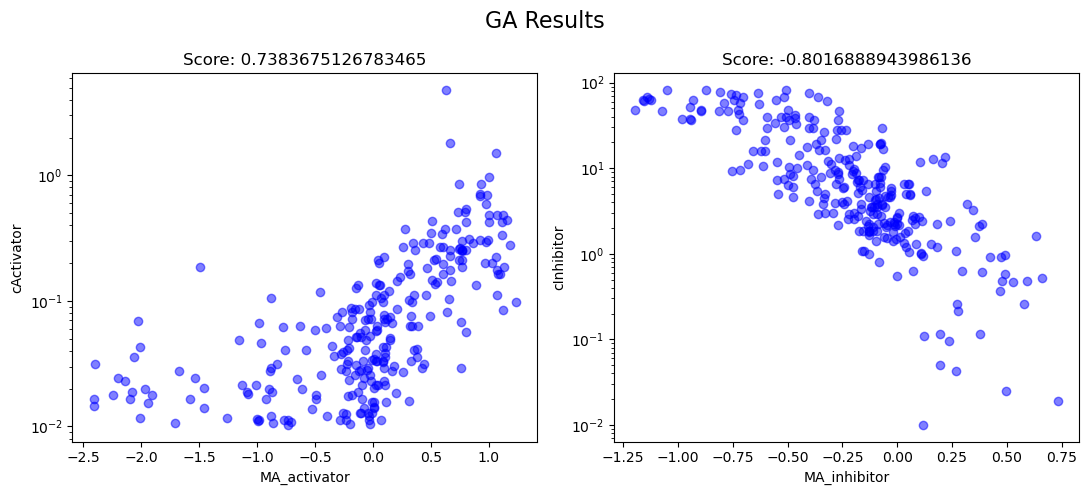

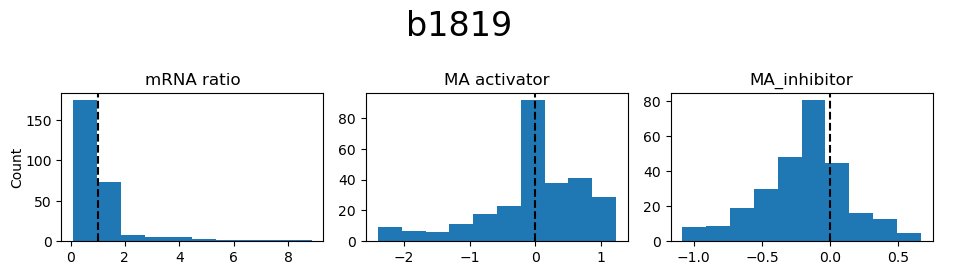

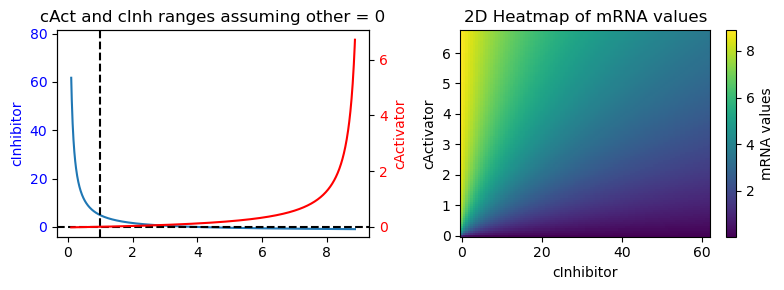

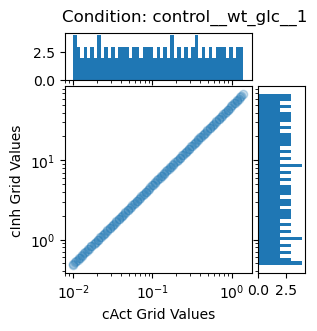

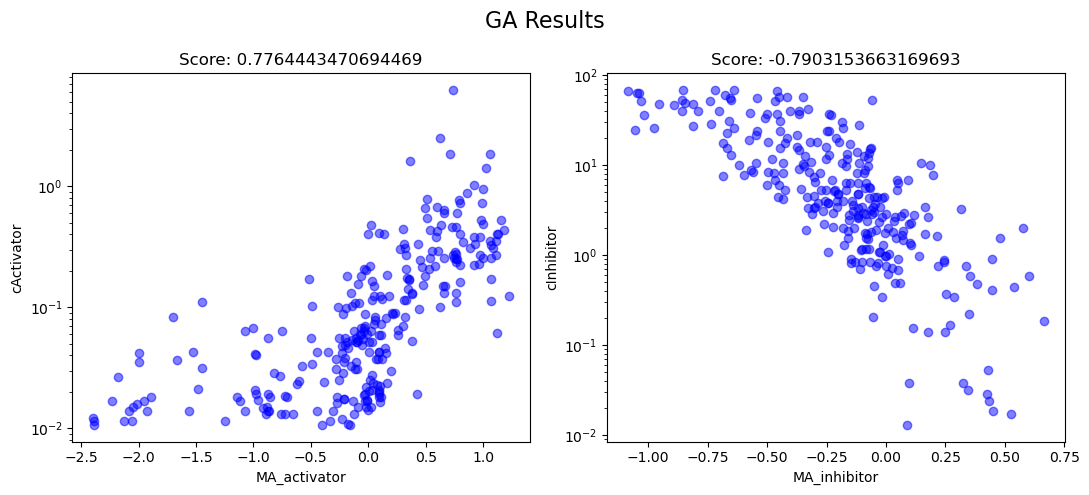

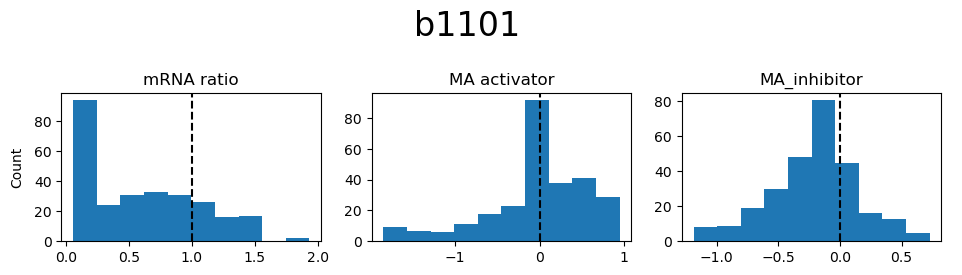

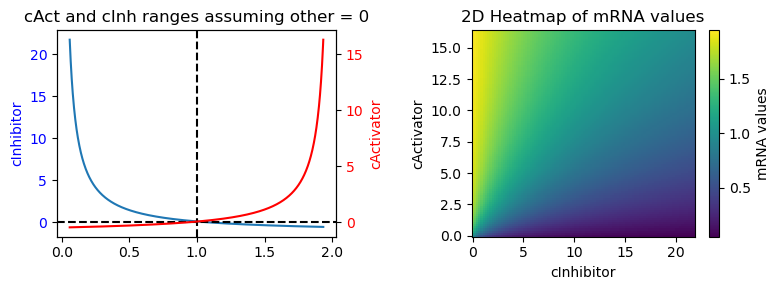

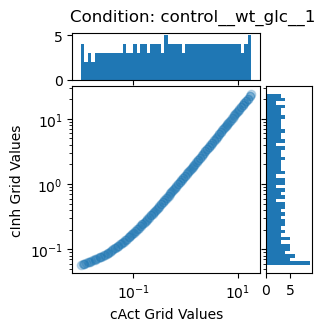

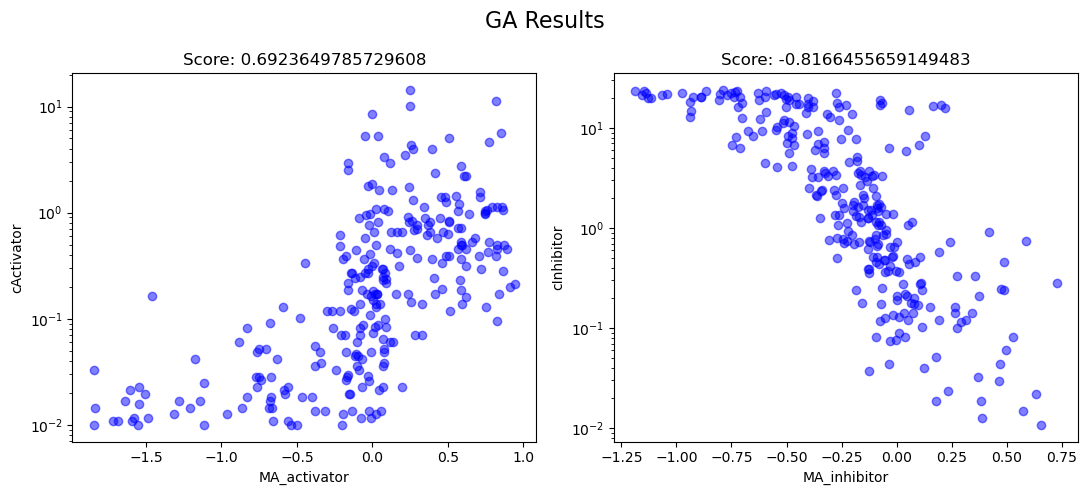

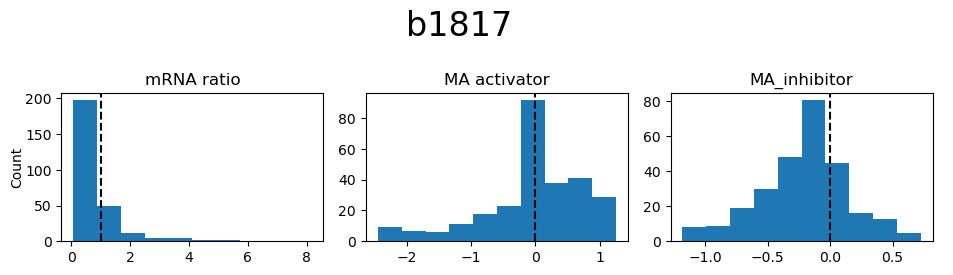

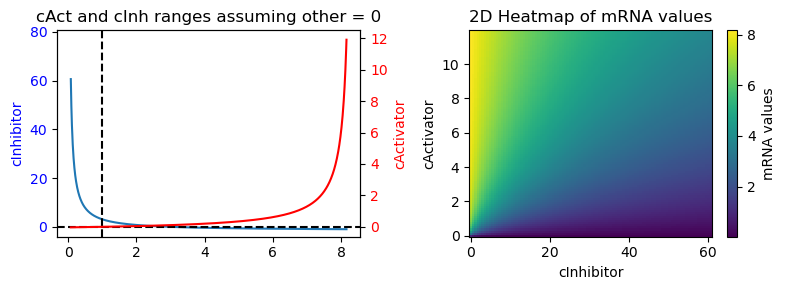

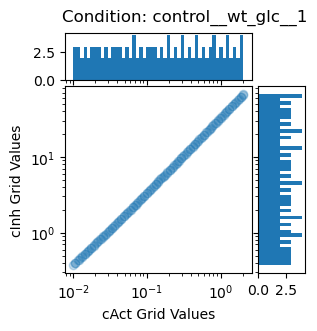

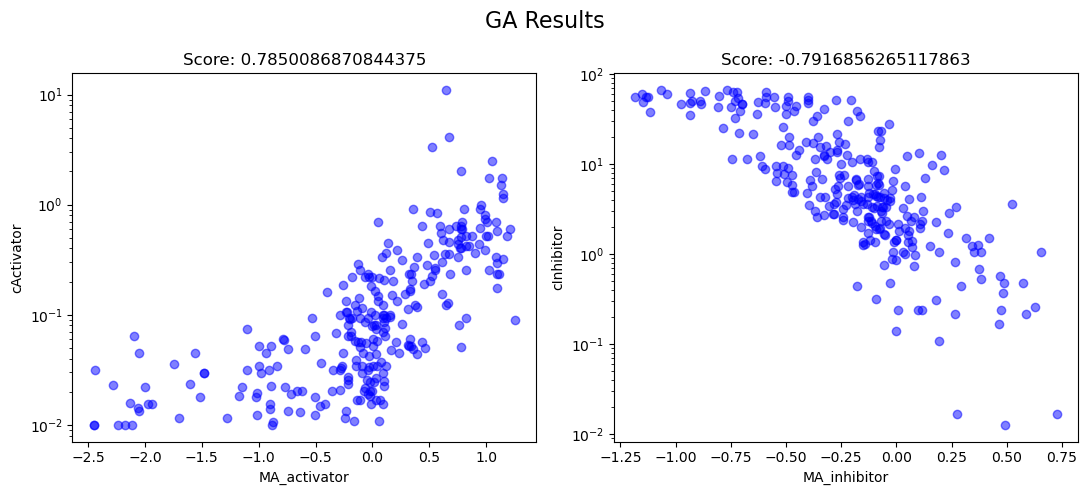

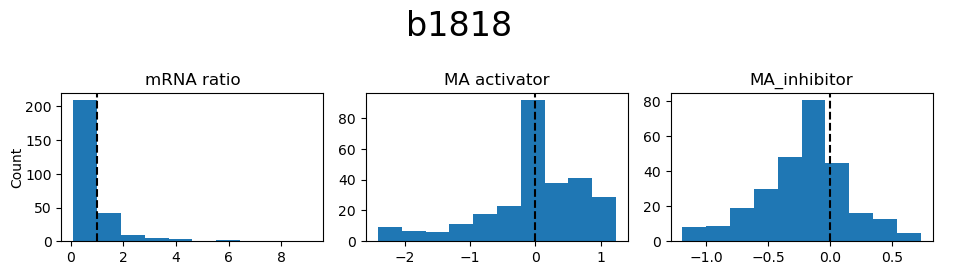

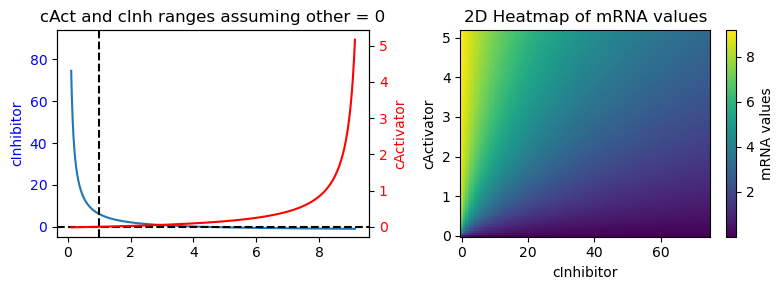

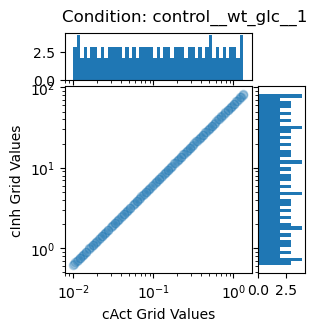

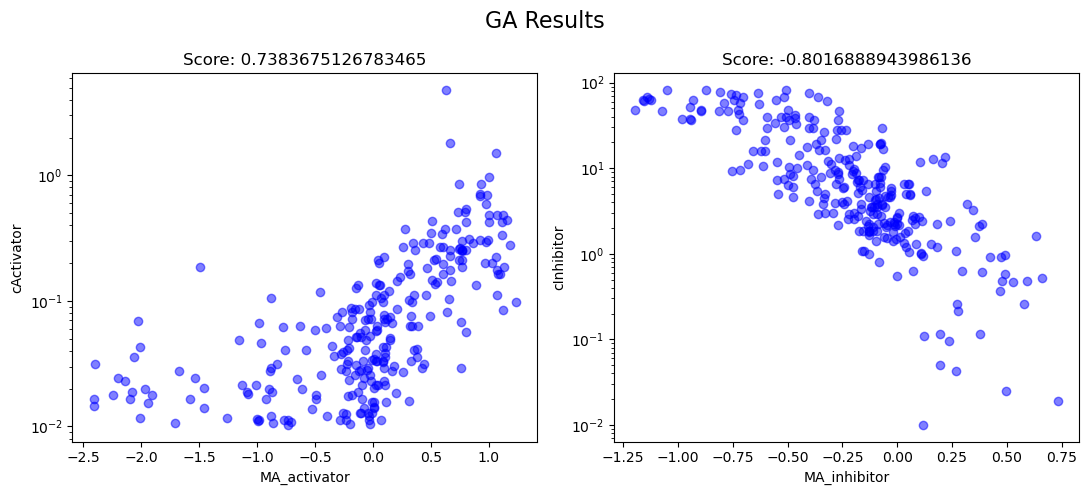

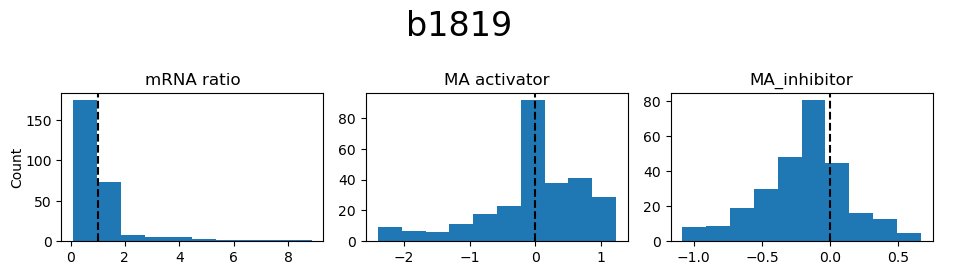

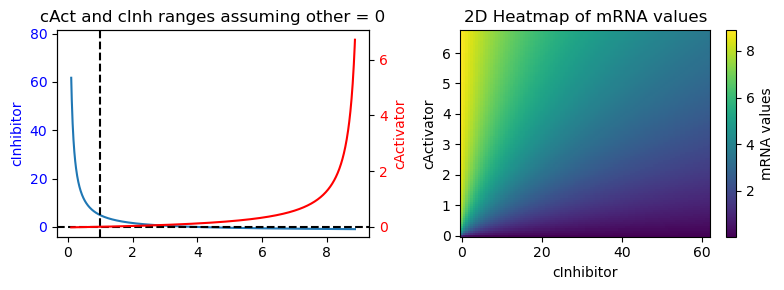

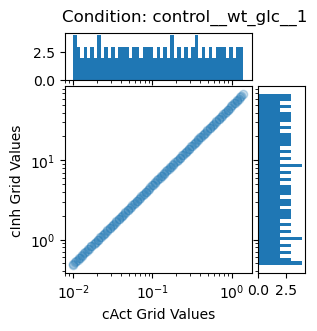

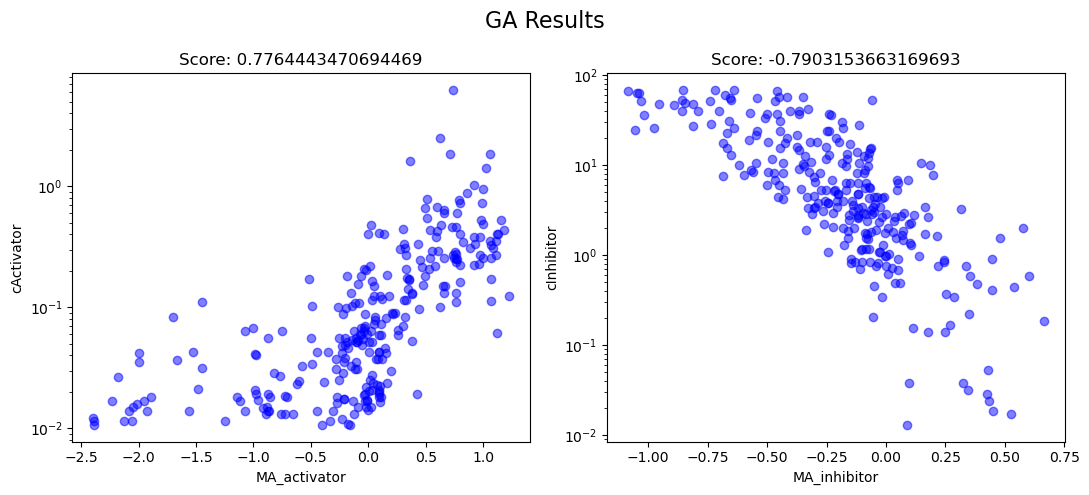

In [3]:
# display gene specific results
for gene, result in zip(genes, results):
    result[0].suptitle(gene, fontsize = 24)
    result[0].tight_layout()
    for res in result:
        show_figure(res)
        display(plt.gcf())
    print('\n\n\n')

In [2]:
iG.run_GAMs(flags, 'b3357', cell_constants)

--- Job cAct_model Start 11/06/23 14:39:26 44.1.1 27c4d1f8 LEX-LEG x86 64bit/Linux
--- Applying:
    /opt/gams/gams44.1_linux_x64_64_sfx/gmsprmun.txt
--- GAMS Parameters defined
    Input /home/chris/github/regulonML/GAMs/cAct_model.gms
    ScrDir /home/chris/github/regulonML/GAMs/225a/
    SysDir /opt/gams/gams44.1_linux_x64_64_sfx/
Licensee: GAMS Demo, for EULA and demo limitations see   G230706/0001CB-GEN
          https://www.gams.com/latest/docs/UG%5FLicense.html         DC0000
          /opt/gams/gams44.1_linux_x64_64_sfx/gamslice.txt
          Demo license for demonstration and instructional purposes only
Processor information: 2 socket(s), 12 core(s), and 24 thread(s) available
GAMS 44.1.1   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- cAct_model.gms(10) 2 Mb
--- call csv2gdx ../data/save_for_GAMs/composite_cAct_vals.csv id=cEff index=1 values=2..lastCol useHeader=y trace=0 output=./input_GDX/input.gdx
--- cAct_model.gms(11) 2 Mb
--

In [3]:
actual_TF_conc = pd.read_csv('../data/save_for_GAMs/exported_TF_conc.csv', index_col = 0)

In [4]:
# run GAMs
if flags['force_rerun']:
    iG.run_GAMs(flags, 'b3357', cell_constants)

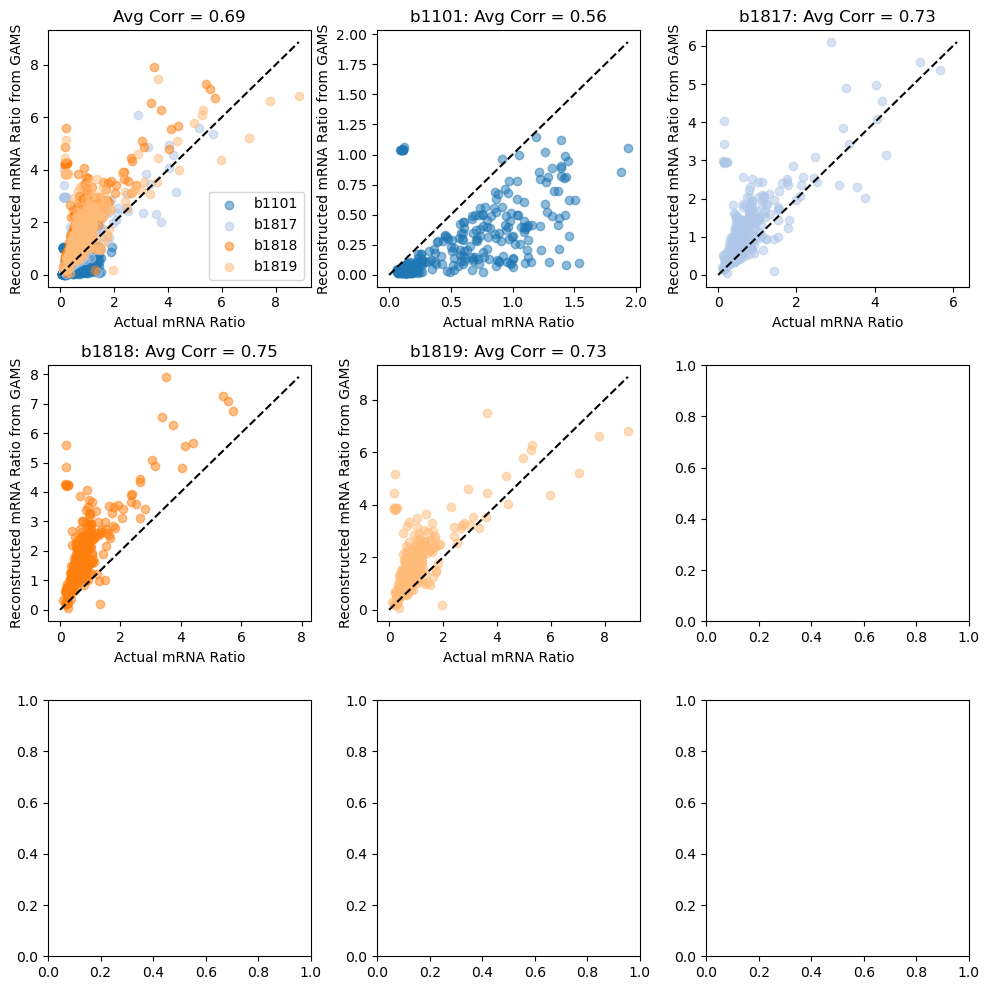

KeyError: "None of [Index(['nac_ntrc__bw_delnac_nh4__2', 'pal__arab_ale16__1', 'pgi__pgi_ale3__1',\n       'ica__tyr_glcn__2', 'pgi__pgi_ale6__1', 'efeU__menFentC_ale39__2',\n       'glu__glu_ale10__1', 'oxidative__delsoxr_pq__2',\n       'nac_ntrc__bw_delnac_csn__1', 'ssw__xyl_ale1__1',\n       ...\n       'misc__bw_delcbl__2', 'ytf__delyddM__2', 'crp__delcrp_fru__2',\n       'ica__wt_glc__2', 'ica__wt_glc__6', 'pgi__pgi_ale8__1',\n       'ytf__delyeiE__1', 'ytf__wt_ph5__2', 'pal__tartr_ale26_f10__2',\n       'rpoB__wt_031__1'],\n      dtype='object', length=271)] are in the [index]"

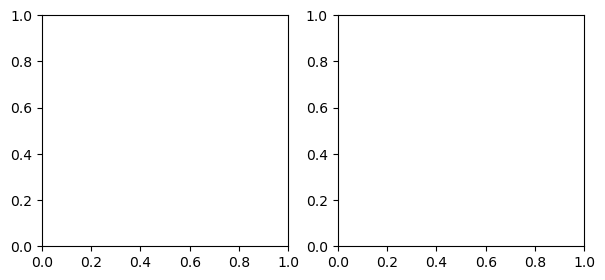

In [5]:
# read and display GAMs
calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs(flags)
if flags['sanity_plots']:
    # loading
    actual_TF_conc = pd.read_csv('../data/save_for_GAMs/exported_TF_conc.csv', index_col = 0)
    actual_TF_conc = 10**actual_TF_conc
    
    # I need recreated cActivators and cInhibitors
    colors = iter(plt.cm.tab20.colors)
    shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    corrs = []
    max_mRNA = 0
    dims = int(np.sqrt(len(calc_cAct.columns)))+1
    fig, axs = plt.subplots(dims, dims, figsize = (10, 10))
    axs = axs.flatten()
    #plt.figure(figsize = (4, 4))
    g_ct = 1
    for gene in calc_cAct.columns:
        # load grid constants
        gene_grid_name = '../data/gene_grid_constants/'+gene+'.pkl'
        pickle_in = open(gene_grid_name, 'rb')
        grid = pickle.load(pickle_in)
        pickle_in.close()
        
        df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
        ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)

        # setup
        po.create_shared_lambda_df(flags['eq_str'], grid)
        
        recon_mRNA = []
        for cAct, cInh in zip(calc_cAct[gene].loc[shared], calc_cInh[gene].loc[shared]):
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid['KdRNAPCrp']))

        actual_mRNA = ratios_df.loc[shared]['actual_mRNA_ratio'].values.flatten()
        if max([max(actual_mRNA), max(recon_mRNA)]) > max_mRNA:
            max_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
        max_bby_mRNA = max([max(actual_mRNA), max(recon_mRNA)])

        corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
        corrs.append(corr[0][1])
        c = next(colors)
        axs[0].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].plot([0, max_bby_mRNA], [0, max_bby_mRNA], ls = '--', c = 'k')
        axs[g_ct].set_title(gene+': Avg Corr = {:.2f}'.format(corr[0][1]))
        axs[g_ct].set_xlabel('Actual mRNA Ratio')
        axs[g_ct].set_ylabel('Reconstructed mRNA Ratio from GAMS')
        g_ct += 1


    axs[0].plot([0, max_mRNA], [0, max_mRNA], ls = '--', c = 'k')
    axs[0].legend()
    axs[0].set_title('Avg Corr = {:.2f}'.format(np.mean(corrs)))
    axs[0].set_xlabel('Actual mRNA Ratio')
    axs[0].set_ylabel('Reconstructed mRNA Ratio from GAMS')
    plt.tight_layout()
    plt.show()
    
    
    
    # TF conc values
    # histogram of TF_conc values
    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
    fig, axs = plt.subplots(1, 2, figsize = (7, 3))
    axs[0].scatter(TF_conc_df.T.loc[shared], actual_TF_conc.loc[shared], alpha = 0.2)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Actual TF Concentration')
    axs[0].set_ylabel('Predicted TF Concentration')
    axs[0].set_title('cActivator Calculations')

    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
    axs[1].scatter(TF_conc_df.T.loc[shared], actual_TF_conc.loc[shared], alpha = 0.2)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Actual TF Concentration')
    axs[1].set_ylabel('Predicted TF Concentration')
    axs[1].set_title('cInhibitor Calculations')
    plt.tight_layout()
    plt.show()

In [29]:





log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
mRNA_target = 2**log_tpm_df*10**-6*cell_constants['mRNA_total']/cell_constants['cell_volume']/(6.022*10**23)




In [6]:
actual_TF_conc

,control__wt_glc__1,control__wt_glc__2,fur__wt_dpd__1,fur__wt_dpd__2,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_dpd__1,fur__delfur_dpd__2,fur__delfur_fe2__1,fur__delfur_fe2__2,...,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
b0002,6.149847e-09,6.699687e-09,9.978683e-09,1.133031e-08,6.402821e-09,5.252373e-09,3.011118e-09,3.745175e-09,7.178412e-09,7.100709e-09,...,3.694106e-09,3.707543e-09,6.785412e-09,6.889865e-09,9.784528e-09,1.012602e-08,1.127791e-08,1.160870e-08,8.635672e-09,8.979653e-09
b0003,4.082781e-09,4.398574e-09,8.211995e-09,1.068622e-08,5.244779e-09,4.632235e-09,2.314548e-09,3.495262e-09,5.703454e-09,5.559886e-09,...,3.420456e-09,3.319023e-09,3.805853e-09,4.017086e-09,5.777015e-09,5.748459e-09,6.223913e-09,6.286793e-09,4.718077e-09,5.198493e-09
b0004,4.622807e-09,5.059378e-09,4.202268e-09,5.252702e-09,4.024667e-09,3.312333e-09,1.279443e-09,1.620151e-09,3.479908e-09,3.430818e-09,...,4.254433e-09,4.136039e-09,4.902234e-09,5.055490e-09,6.760864e-09,6.619025e-09,6.958097e-09,7.238761e-09,5.926186e-09,6.125826e-09
b0005,2.381594e-10,2.288377e-10,1.281608e-10,1.207436e-10,3.142462e-10,2.543280e-10,7.385539e-11,8.077490e-11,2.757727e-10,2.102337e-10,...,1.885445e-10,1.559855e-10,2.365174e-10,2.341067e-10,9.961005e-11,8.534486e-11,1.304885e-10,1.617513e-10,1.752956e-10,1.675329e-10
b0006,3.608994e-10,3.563817e-10,3.274945e-10,3.290783e-10,3.243698e-10,3.369088e-10,3.079279e-10,3.472229e-10,3.477313e-10,3.371303e-10,...,9.897837e-10,9.567994e-10,8.417201e-10,8.042609e-10,4.890416e-10,4.929228e-10,4.802973e-10,4.758765e-10,7.964459e-10,8.230837e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4688,1.659696e-11,2.384307e-11,7.405471e-12,2.989040e-12,2.256579e-11,2.841473e-11,5.170219e-12,4.998418e-12,2.082449e-11,1.228518e-11,...,1.076947e-11,1.443688e-11,2.989040e-12,7.275389e-12,7.648112e-12,6.712043e-12,9.949077e-12,6.010959e-12,2.989040e-12,8.724690e-12
b4693,5.458847e-12,8.035653e-12,1.701656e-11,1.343399e-11,1.009531e-11,1.314140e-11,3.901404e-11,2.924727e-11,5.761502e-11,5.698037e-11,...,5.107237e-12,1.199266e-11,2.989040e-12,3.767003e-12,2.751177e-11,2.393626e-11,2.572720e-11,2.547637e-11,3.113835e-11,2.693222e-11
b4696_1,1.871578e-11,1.744970e-11,4.056301e-11,3.724643e-11,1.250312e-11,1.207566e-11,3.405305e-11,2.999858e-11,1.654574e-11,1.612929e-11,...,2.166449e-11,2.191859e-11,2.077456e-11,1.785031e-11,1.988813e-11,1.967025e-11,2.563529e-11,2.426610e-11,2.795511e-11,3.159451e-11
b4696_2,2.535865e-11,2.649618e-11,4.468232e-11,4.774945e-11,1.862009e-11,1.373670e-11,4.632318e-11,4.517498e-11,2.466424e-11,2.591146e-11,...,1.833703e-11,3.417436e-11,2.771640e-11,2.412760e-11,1.808800e-11,3.970977e-11,3.290006e-11,3.875599e-11,3.342752e-11,4.218526e-11


# depreceated - creation of the pipeline (leave here for now)

In [10]:
# import statements
import os
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from IPython.display import display
import multiprocessing

import sys
sys.path.insert(0, '../functions/')
import basal_model_calcs as bmc
import mRNA_ratios as mr
import parameter_optimization as po
import create_cAct_cInh_vals as cv
import interface_GAMS as iG

In [2]:
# settings
flags = { # add additional settings that should be changed between runs here
    # general flags
    'force_rerun' : True,
    'sanity_plots' : True,
    'central_gene' : 'b1819',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'basal_or_hard_val' : 'basal', # use basal conditions for ratio or some hard value
    'hard_val' : 10, # the basal log tpm value
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest

    # picking KdRNAPCrp values
    'initial_guess_ratio' : .3, # this commonly needs to get raised and lowered to get a good value, eventually I will figure out a way to automate it if this step stays in the pipeline
    'base_cInhibitor_val' : 0.1, # this is the set minimum value to solve cActivator based on to set its dynamic range
    'base_cActivator_val' : 0.1, # defines the range of cInhibitor values available
    
    # cAct & cInh Grid flags
    'auto_set_max_range' : True, # if True, set the range based on the set to zero values of the KdRNAPCrp calculator
    'additional_tolerance' : 0.10, # add this %age of the maximum to the top
    'cActivator' : [-2,2], # Uses a log10 range
    'cInhibitor': [-2,2], # Uses a log10 range
    'run_greedy' : False, # skips greedy algo to save time

    # GA - best cActivator/cInhibitor flags
    'neg_grid_toss_OR_zero' : 'toss', # options: toss or zero, what to do with negative grid values
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 100, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook
    
    # greedy
    'n_iter' : 5, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual

    # GAMs
    'use_greedy' : False, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b1101', 'b1817', 'b1818', 'b1819'] # if run_on_all is False, limit to these samples (or which of them are available)
}


gene_to_act_inh_iMs = {
    'b1101' : ['Crp-2', 'DhaR/Mlc'],
    'b1817' : ['Crp-2', 'DhaR/Mlc'],
    'b1818' : ['Crp-2', 'DhaR/Mlc'],
    'b1819' : ['Crp-2', 'DhaR/Mlc'],
    'b2151' : ['Crp-1', 'Crp-2'],
    'b3601' : ['Crp-1', 'Crp-2'],
    'b2239' : ['Crp-2', 'GlpR'],
    'b2240' : ['Crp-2', 'GlpR'],
    'b0723' : ['Crp-2', 'ArcA-1'],
    'b1415' : ['Crp-2', 'Crp-1'],
    'b2597' : ['Crp-2', 'CpxR'],
    'b3403' : ['Crp-2', 'crp-KO'],
    'b4267' : ['Crp-2', 'GntR/TyrR'],
    'b2143' : ['Crp-2', 'YieP'],
}

# Grid constants, use these if basal_bool = False
# NOTE: The names of these variables must match the sympy equation
t_half_life_deg = 300
grid_constants = {
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    #'KeqOpening': 10**-0.34444956947383365, gets set later
    'RNAP': 10**-6,
    'mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'k_d_TF': 1, # May change depending on model
    'kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'promoterConcVal': 10**-9, # Promoter concentration
    'TF': 0, # Concentration of TF
    'u': 1/3600, # Growth Rate
}

eq_str = 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))'

gene_grid_name = '../data/gene_grid_constants/'+flags['central_gene']+'.pkl'
if os.path.exists(gene_grid_name):
    pickle_in = open(gene_grid_name, 'rb')
    gene_grid_constants = pickle.load(pickle_in)
    pickle_in.close()
else:
    gene_grid_constants = {}
    
# Set reproducible random seed used by the GA
rng = np.random.default_rng(seed = flags['seed'])

# collect figures
gene_figs = []
together_figs = []

In [3]:
# to do
# 1 - add sanity plots, likely collected throughout
# 2 - better enforce flags['force_rerun'] to save runtime
# 3 - put "per every gene" functions into one function
# 4 - figure out scaled TF concentration

## per every gene

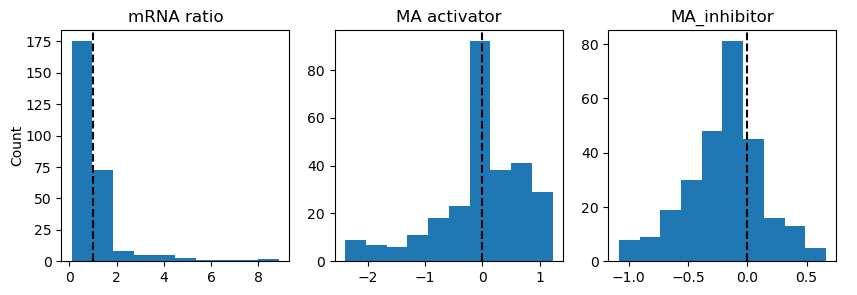

In [4]:
# create mRNA ratios and MA values
df_name = flags['central_gene']+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
if not flags['force_rerun'] and os.path.exists('../data/saved_mRNA_ratios_MA_vals/'+df_name):
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
else:
    ratios_df = mr.calculate_mRNA_ratios_and_MA_values(gene_to_act_inh_iMs[flags['central_gene']][0], gene_to_act_inh_iMs[flags['central_gene']][1], flags)
    ratios_df.to_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name)
if flags['sanity_plots']:
    # sanity check plot
    fig, axs = plt.subplots(1, 3, figsize = (10, 3))
    axs[0].hist(ratios_df.actual_mRNA_ratio)
    axs[0].set_title('mRNA ratio')
    axs[0].axvline(x = 1, c = 'k', ls = '--')
    axs[1].hist(ratios_df.MA_activator)
    axs[1].set_title('MA activator')
    axs[1].axvline(x = 0, c = 'k', ls = '--')
    axs[2].hist(ratios_df.MA_inhibitor)
    axs[2].set_title('MA_inhibitor')
    axs[2].axvline(x = 0, c = 'k', ls = '--')
    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.ylabel('Count')
    gene_figs.append(fig)
    #plt.show()

In [5]:
# create TF concentration # TODO, CHECK THIS
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
scaled_df = 2**log_tpm_df / (2**log_tpm_df).sum()

# save of TF concentrations of baseline values
# for now, it's just always crp
# goofy, scaling to same range/units as are used in GAMs
scaled_df.loc['b3357'].to_csv('../data/save_for_GAMs/exported_TF_conc.csv')

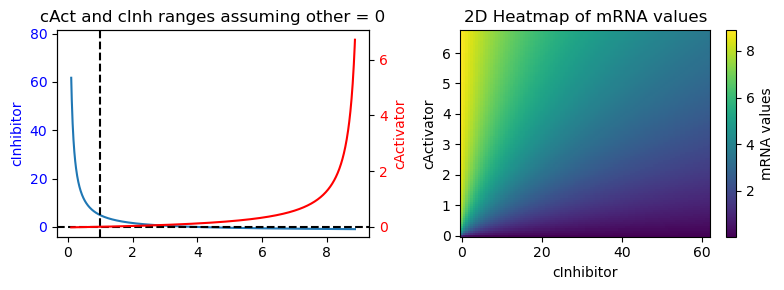

In [6]:
# pick KdRNAPCrp value, limit cActivator and cInhibitor based on it
# load in calculator
gene_grid_name = '../data/gene_grid_constants/'+flags['central_gene']+'.pkl'
if flags['force_rerun'] or not os.path.exists(gene_grid_name):  
    # basal model calculations
    grid_constants = bmc.basal_values(grid_constants, eq_str, flags)
    
    # pick KdRNAPCrp
    po.create_shared_lambda_df(eq_str, grid_constants)
    grid_constants['KdRNAPCrp'] = po.pick_KdRNAPCrp(ratios_df, flags)

    # save off grid constants
    pickle_out = open(gene_grid_name, 'wb')
    pickle.dump(grid_constants, pickle_out)
    pickle_out.close()
else:
    pickle_in = open(gene_grid_name, 'rb')
    grid_constants = pickle.load(gene_grid_name)
    pickle_in.close()
if flags['sanity_plots']:
    # sanity check plot

    # if you get weird results here, look at egulonML/parameter_optimization/0_framework.ipynb
    # it does the same thing as the function with plots along the way
    # try adjusting the initial guess for the first optimization
    # that is line 74 of functions/parameter_optimization.py

    # however, it is a sanity check to see if these values are near-correct
    rat_vals = np.linspace(min(ratios_df['actual_mRNA_ratio'].values.flatten()), max(ratios_df['actual_mRNA_ratio'].values.flatten()), 1000)

    cInh_vals = [po.mRNA_cActivator_to_cInhibitor(rat_val, flags['base_cActivator_val'], grid_constants['KdRNAPCrp']) for rat_val in rat_vals]
    cAct_vals = [po.mRNA_cInhibitor_to_cActivator(rat_val, flags['base_cInhibitor_val'], grid_constants['KdRNAPCrp']) for rat_val in rat_vals]

    fig, axs = plt.subplots(1, 2, figsize = (8, 3))
    ax1 = axs[0]
    l1, = ax1.plot(rat_vals, cInh_vals)
    plt.xlabel('mRNA Ratio')
    ax1.set_ylabel('cInhibitor', color = 'blue')
    ax1.tick_params(axis = 'y', labelcolor = 'blue')
    ax2 = ax1.twinx()
    l2, = ax2.plot(rat_vals, cAct_vals, color = 'red')
    ax2.set_ylabel('cActivator', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax1.axhline(y = 0, ls = '--', c = 'k')
    ax1.axvline(x = 1, ls = '--', c = 'k')
    # let's rescale cInhibitor (ax1) so that 0 is at the same point
    m1, M1 = ax1.get_ylim()
    percent1_up = (0 - m1) / (M1 - m1)
    m2, M2 = ax2.get_ylim()
    percent2_up = (0 - m2) / (M2 - m2)

    if percent1_up < percent2_up:
        # zero is higher than it should, so adjust it down by lowering the min
        m1 = percent2_up * M1 / (percent2_up - 1)
        ax1.set_ylim(m1, M1)
    else:
        # zero is lower than it should, so adjust it up
        M1 = m1 - (m1 / percent2_up)
        ax1.set_ylim(m1, M1)

    ax1.set_title('cAct and cInh ranges assuming other = 0')

    if flags['auto_set_max_range']:
        flags['cActivator'] = [-2, math.log10((1+flags['additional_tolerance'])*max(cAct_vals))] # Uses a log10 range
        flags['cInhibitor'] = [-2, math.log10((1+flags['additional_tolerance'])*max(cInh_vals))] # Uses a log10 range

    # let's create a 2D heatmap version of this, colored by the mRNA ratio
    cInh_range = np.linspace(0, max(cInh_vals), 100)
    cAct_range = np.linspace(0, max(cAct_vals), 100)
    mRNA_vals = pd.DataFrame(index = cInh_range, columns = cAct_range)
    for cInh in mRNA_vals.index:
        for cAct in mRNA_vals.columns:
            mRNA_vals.loc[cInh][cAct] = po.cActivator_cInhibitor_to_mRNA(cAct, cInh, grid_constants['KdRNAPCrp'])
    mRNA_vals = mRNA_vals.T.astype(float)

    # Convert the cInh_range and cAct_range to meshgrids for plotting
    cInh, cAct = np.meshgrid(cInh_range, cAct_range)

    # Create the heatmap
    heatmap = axs[1].pcolormesh(cInh, cAct, mRNA_vals.values, shading='auto', cmap='viridis')
    plt.colorbar(heatmap, label='mRNA values')
    axs[1].set_xlabel('cInhibitor')
    axs[1].set_ylabel('cActivator')
    axs[1].set_title('2D Heatmap of mRNA values')
    plt.tight_layout()
    gene_figs.append(fig)

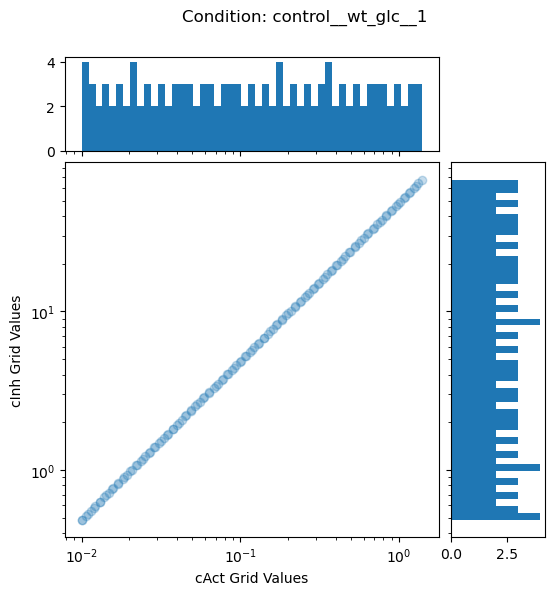

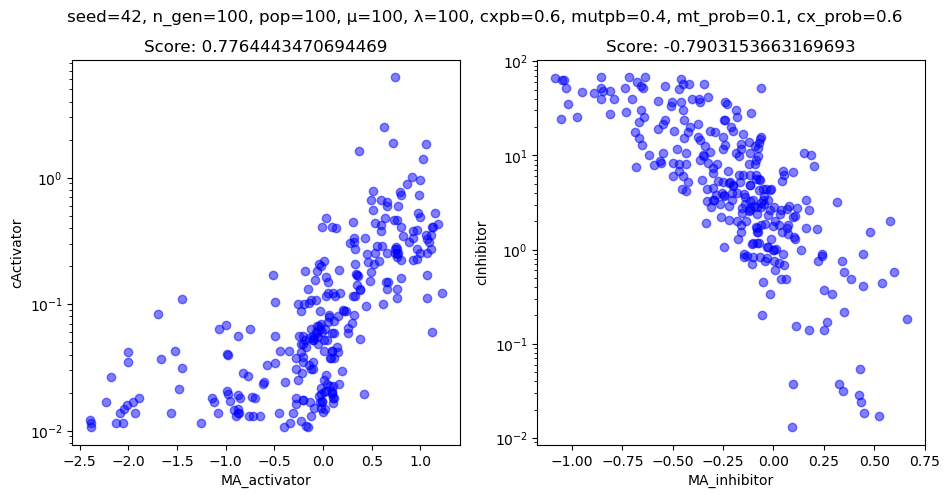

In [7]:
# determine cActivator and cInhibior values, and greedy
greedy_path = '../data/cAct_cInh_vals/'+flags['central_gene']+'_greedy.pkl'
norm_path = '../data/cAct_cInh_vals/'+flags['central_gene']+'.pkl'
if flags['force_rerun']:
    return_figs, greedy_cAct_cInh_df, cAct_cInh_df = cv.create_cAct_cInh_for_gene(ratios_df, grid_constants, eq_str, flags)
    if flags['run_greedy']:
        pickle_out = open(greedy_path, 'wb')
        pickle.dump(greedy_cAct_cInh_df, pickle_out)
        pickle_out.close()
        pickle_out = open(norm_path, 'wb')
        pickle.dump(cAct_cInh_df, pickle_out)
        pickle_out.close()
    else:
        pickle_out = open(norm_path, 'wb')
        pickle.dump(cAct_cInh_df, pickle_out)
        pickle_out.close()
else:
    if flags['run_greedy'] and os.path.exists(norm_path):
        pickle_in = open(norm_path, 'rb')
        cAct_cInh_df = pickle.load(pickle_in)
        pickle_in.close()
    elif os.path.exists(norm_path) and os.path.exists(greedy_path):
        pickle_in = open(norm_path, 'rb')
        cAct_cInh_df = pickle.load(pickle_in)
        pickle_in.close()
        pickle_in = open(greedy_path, 'rb')
        greedy_cAct_cInh_df = pickle.load(pickle_in)
        pickle_in.close()
    else: # need to rerun
        return_figs, greedy_cAct_cInh_df, cAct_cInh_df = cv.create_cAct_cInh_for_gene(ratios_df, grid_constants, eq_str, flags)
        if flags['run_greedy']:
            pickle_out = open(greedy_path, 'wb')
            pickle.dump(greedy_cAct_cInh_df, pickle_out)
            pickle_out.close()
            pickle_out = open(norm_path, 'wb')
            pickle.dump(cAct_cInh_df, pickle_out)
            pickle_out.close()
        else:
            pickle_out = open(norm_path, 'wb')
            pickle.dump(cAct_cInh_df, pickle_out)
            pickle_out.close()
for fig in return_figs:
    gene_figs.append(fig)

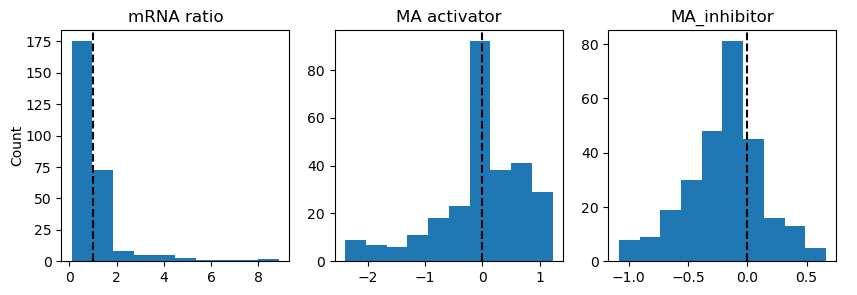

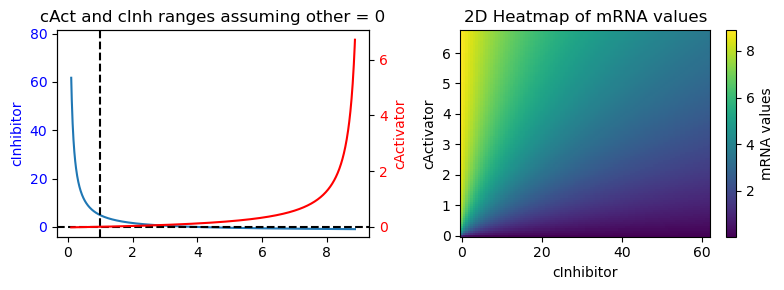

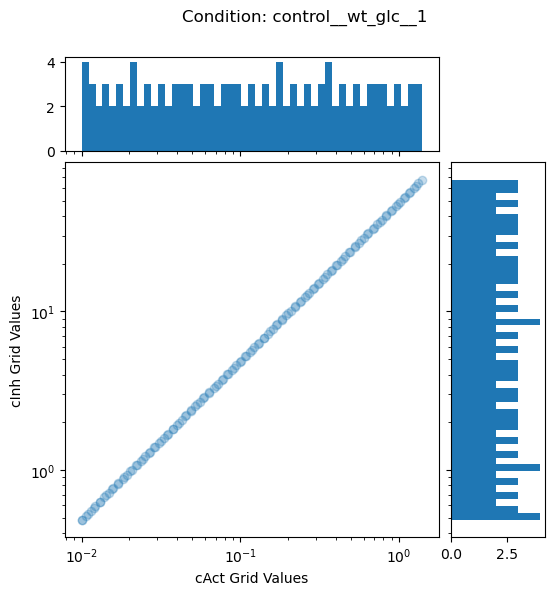

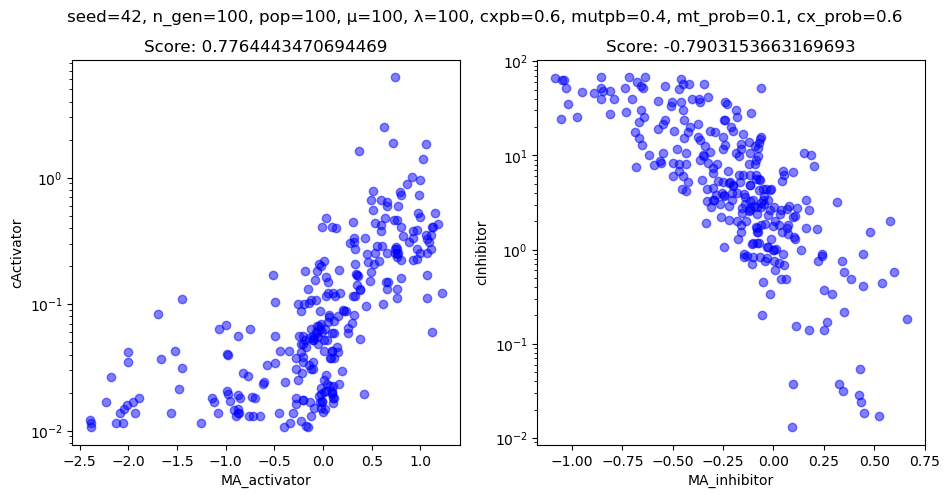

In [8]:
# show our gene_specific sanity plots
for fig in gene_figs:
    display(fig)

## don't do per gene

In [6]:
# run GAMs
if flags['force_rerun']:
    iG.run_GAMs(flags)

--- Job cAct_model Start 11/03/23 11:57:18 44.1.1 27c4d1f8 LEX-LEG x86 64bit/Linux
--- Applying:
    /opt/gams/gams44.1_linux_x64_64_sfx/gmsprmun.txt
--- GAMS Parameters defined
    Input /home/chris/github/regulonML/GAMs/cAct_model.gms
    ScrDir /home/chris/github/regulonML/GAMs/225a/
    SysDir /opt/gams/gams44.1_linux_x64_64_sfx/
Licensee: GAMS Demo, for EULA and demo limitations see   G230706/0001CB-GEN
          https://www.gams.com/latest/docs/UG%5FLicense.html         DC0000
          /opt/gams/gams44.1_linux_x64_64_sfx/gamslice.txt
          Demo license for demonstration and instructional purposes only
Processor information: 2 socket(s), 12 core(s), and 24 thread(s) available
GAMS 44.1.1   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- cAct_model.gms(10) 2 Mb
--- call csv2gdx ../data/save_for_GAMs/composite_cAct_vals.csv id=cEff index=1 values=2..lastCol useHeader=y trace=0 output=./input_GDX/input.gdx
--- cAct_model.gms(11) 2 Mb
--

    461   4        2.7240493608E+02 9.9E-06   253 2.1E-04    2 F  T
    466   4        2.7240493608E+02 9.9E-06   252 8.3E-04    1 F  T
    471   4        2.7240493607E+02 9.7E-06   251 5.2E-01    1 F  T
    481   4        2.7240493605E+02 9.7E-06   250 9.4E+00    1 F  T
    491   4        2.7240493604E+02 9.7E-06   249 1.0E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    496   4        2.7240493603E+02 9.9E-06   249 9.9E-05    1 F  T
    501   4        2.7240493603E+02 9.7E-06   249 1.0E+00      F  T
    506   4        2.7240493603E+02 9.9E-06   249 7.3E-05    1 F  T
    511   4        2.7240493603E+02 9.9E-06   249 1.8E-05    1 F  T
    516   4        2.7240493602E+02 9.7E-06   249 1.0E+00    1 F  T
    521   4        2.7240493600E+02 9.7E-06   249 1.0E+00    1 F  T
    531   4        2.7240493592E+02 9.9E-06   249 5.3E-06      F  T
    536   4        2.7240493587E+02 9.9E-06   249 4.4E-04    1 F  T
    541   4        2.7240493587E+02 9.7E-06  

     81   4        2.9753577726E+02 6.8E-01   107 4.3E+00      F  T
     86   4        2.9701070257E+02 1.5E+00   106 1.0E+01    1 F  T
     91   4        2.9688536133E+02 6.3E-01   104 2.4E-02    1 F  T
    101   4        2.9562864096E+02 2.2E+00   124 5.1E-01      F  T
    106   4        2.9508489116E+02 8.0E-01   123 4.2E-02    1 F  T
    111   4        2.9489105321E+02 8.7E-01   123 1.0E+00    1 F  T
    116   4        2.9484054932E+02 1.9E-01   122 8.8E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    121   4        2.9482663275E+02 6.2E-01   121 1.0E+00    1 F  T
    126   4        2.9481534737E+02 1.9E-01   120 1.0E+00    1 F  T
    131   4        2.9377337356E+02 1.4E+00   139 1.0E+00      F  T
    141   4        2.9273125766E+02 1.1E+00   136 1.0E+01    1 F  T
    146   4        2.9265858379E+02 3.5E-01   135 1.8E+00    1 F  T
    151   4        2.9262161405E+02 7.4E-01   133 1.0E-02    1 F  T
    156   4        2.9261135576E+02 5.3E-01  

    751   4        2.8617128768E+02 1.2E+00   121 4.8E-06    1 F  T
    756   4        2.8617118139E+02 7.0E-01   121 1.9E+01    1 F  T
    761   4        2.8617055504E+02 8.2E-01   121 3.4E-05    1 F  T
    766   4        2.8617010236E+02 1.8E+00   121 1.3E-01    1 F  T
    771   4        2.8616955617E+02 1.5E+00   120 1.4E-02      F  T
    781   4        2.8616815359E+02 5.3E-01   119 6.9E-05    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    786   4        2.8616760896E+02 2.9E+00   118 1.0E+00    1 F  T
    791   4        2.8615153617E+02 2.1E+00   125 4.1E+00    1 F  T
    796   4        2.8613266810E+02 8.9E-01   123 7.6E+00    1 F  T
    801   4        2.8604123566E+02 1.7E+00   122 1.8E-01      F  T
    811   4        2.8601272269E+02 7.9E-01   120 4.2E+00    1 F  T
    816   4        2.8600986677E+02 1.6E+00   119 1.0E+00    1 F  T
    821   4        2.8600794352E+02 7.6E-01   119 6.9E-01    1 F  T
    826   4        2.8600590993E+02 7.0E-01  

   1461   4        2.8493571698E+02 1.4E+00    78 6.4E-06    1 F  T
   1466   4        2.8493569491E+02 9.3E-01    77 3.3E+00    1 F  T
   1471   4        2.8493564765E+02 2.1E+00    77 4.5E-06    1 F  T
   1476   4        2.8493557340E+02 5.8E-01    77 1.0E+00    1 F  T
   1481   4        2.8493552500E+02 3.0E+00    77 6.2E-06    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   1486   4        2.8493544058E+02 7.3E-01    77 5.2E-06    1 F  T
   1491   4        2.8493541817E+02 3.6E+00    75 2.0E+01    1 F  T
   1496   4        2.8493538730E+02 1.5E+00    74 3.9E-06    1 F  T
   1501   4        2.8493530240E+02 4.7E+00    78 5.4E-04      F  T
   1511   4        2.8493527506E+02 4.2E+00    78 1.9E+02    1 F  T
   1516   4        2.8493524871E+02 9.8E-01    78 1.6E-05    1 F  T
   1521   4        2.8493523150E+02 6.1E-01    75 1.0E+00    1 F  T
   1531   4        2.8493519858E+02 8.5E-01    73 2.5E-01    1 F  T
   1536   4        2.8493518197E+02 1.1E+00  

   2186   4        2.8438260610E+02 9.2E-01    35 1.3E-07    1 F  T
   2191   4        2.8438260566E+02 1.8E+00    35 6.2E-06      F  T
   2201   4        2.8438260408E+02 9.2E-01    34 4.6E-01    1 F  T
   2206   4        2.8438260362E+02 1.5E+00    33 1.4E-08    1 F  T
   2211   4        2.8438260308E+02 2.4E+00    35 2.8E-08      F  T
   2221   4        2.8438260301E+02 2.4E+00    33 1.0E+00    1 F  T
   2231   4        2.8438260298E+02 1.4E+00    33 2.2E-10      F  T
   2236   4        2.8438260298E+02 2.9E+00    33 5.3E-10    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   2241   4        2.8438260295E+02 8.9E-01    34 1.0E-07      F  T
   2246   4        2.8438260295E+02 1.3E+00    33 4.6E-10    2 F  T
   2251   4        2.8438260293E+02 2.5E+00    33 1.0E+00    1 F  T
   2261   4        2.8438260275E+02 8.1E-01    32 9.4E-06      F  T
   2266   4        2.8438260255E+02 8.1E-01    31 9.4E-10    1 F  T
   2271   4        2.8438260246E+02 8.1E-01  

   2861   4        2.8380788409E+02 9.0E-01    31 1.0E+00    1 F  T
   2866   4        2.8380765051E+02 1.0E+00    31 3.4E-01    1 F  T
   2871   4        2.8380740994E+02 5.4E+00    31 5.5E-05    1 F  T
   2881   4        2.8380575326E+02 9.0E-01    30 4.1E-03      F  T
   2886   4        2.8380357400E+02 1.6E+00    29 1.0E-04    1 F  T
   2891   4        2.8379673050E+02 1.8E+00    29 1.2E-04    1 F  T
   2901   4        2.8379502505E+02 6.9E-01    29 2.7E-06      F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   2906   4        2.8379495559E+02 2.3E+00    28 4.4E+00    1 F  T
   2911   4        2.8379483650E+02 9.0E-01    26 2.4E+00    1 F  T
   2921   4        2.8378456914E+02 2.4E+00    31 2.5E-03    1 F  T
   2926   4        2.8378375628E+02 8.0E-01    29 3.3E+00    1 F  T
   2931   4        2.8378289984E+02 3.0E+00    28 6.3E-02      F  T
   2941   4        2.8378241716E+02 1.4E+00    27 1.0E-04    1 F  T
   2951   4        2.8378225832E+02 6.9E-01  

 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   3611   4        2.8325348363E+02 1.4E+00    38 1.4E+01    1 F  T
   3616   4        2.8319425254E+02 3.3E+00    37 1.1E-02    1 F  T
   3621   4        2.8310027638E+02 1.4E+00    36 1.0E+00    1 F  T
   3626   4        2.8303147467E+02 2.6E+00    37 5.3E-03    1 F  T
   3631   4        2.8301317861E+02 8.2E-01    35 1.0E+00    1 F  T
   3636   4        2.8300222337E+02 1.9E+00    36 4.1E-03    1 F  T
   3641   4        2.8297874207E+02 6.9E-01    33 3.0E-02    1 F  T
   3651   4        2.8293287112E+02 8.2E-01    31 5.0E-01      F  T
   3656   4        2.8291771216E+02 1.8E+00    34 7.2E+00    1 F  T
   3661   4        2.8289358429E+02 1.2E+00    33 1.3E-03    3 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   3671   4        2.8288637857E+02 1.7E+00    30 2.0E+00    1 F  T
   3676   4        2.8288436620E+02 1.3E+00    29 2.0E-04    1 F  T
   3681   4        2.8288382328E+02 1.3E+0

   4321   4        2.8274470564E+02 9.2E-01     8 3.4E-03      F  T
   4331   4        2.8274470440E+02 9.2E-01     8 1.6E-06    1 F  T
   4336   4        2.8274470377E+02 1.9E+00     7 3.3E-07    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   4341   4        2.8274470371E+02 9.2E-01     7 2.9E-11      F  T
   4346   4        2.8274470368E+02 9.6E-01     6 1.5E-08    1 F  T
   4351   4        2.8274470266E+02 8.1E-01     6 1.0E+00    1 F  T
   4361   4        2.8274470263E+02 6.1E-01     6 3.1E-07    1 F  T
   4366   4        2.8274470263E+02 6.1E-01     6 3.1E-07    1 F  T
   4371   4        2.8274469904E+02 1.2E+00    23 3.0E-05      F  T
   4381   4        2.8274292572E+02 1.0E+00    21 1.2E-04      F  T
   4391   4        2.8274254406E+02 1.4E+00    17 4.4E-04    1 F  T
   4401   4        2.8274186375E+02 1.6E+00    15 1.0E+00    1 F  T
   4411   4        2.8274169218E+02 4.8E+00    15 5.8E-06    1 F  T
 
   Iter Phase Ninf     Objective     RGmax 

   5066   4        2.8267906042E+02 9.2E-01    11 6.1E+00    1 F  T
   5071   4        2.8267904707E+02 9.9E-01    10 1.3E-01      F  T
   5076   4        2.8267904408E+02 8.2E-01    10 5.3E-01    1 F  T
   5081   4        2.8267904383E+02 2.6E+00    10 5.8E-08    1 F  T
   5086   4        2.8267904382E+02 1.4E+00     9 4.0E+00    1 F  T
   5091   4        2.8267904377E+02 7.7E-01     8 1.0E+00    1 F  T
   5096   4        2.8267904376E+02 1.1E+00    10 7.2E-09    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   5101   4        2.8267904373E+02 1.8E+00     9 6.4E-09    1 F  T
   5111   4        2.8267902268E+02 1.5E+00     8 1.0E+00    1 F  T
   5116   4        2.8267902207E+02 5.9E-01     8 1.5E-01    1 F  T
   5121   4        2.8267902206E+02 2.2E+00     8 9.5E-09    1 F  T
   5131   4        2.8267902203E+02 8.9E-01     7 1.9E-09    1 F  T
   5136   4        2.8267902203E+02 8.9E-01     5 3.6E-01    1 F  T
   5141   4        2.8267902203E+02 1.4E+00  

AttributeError: module 'interface_GAMS' has no attribute 'read_GAMs'

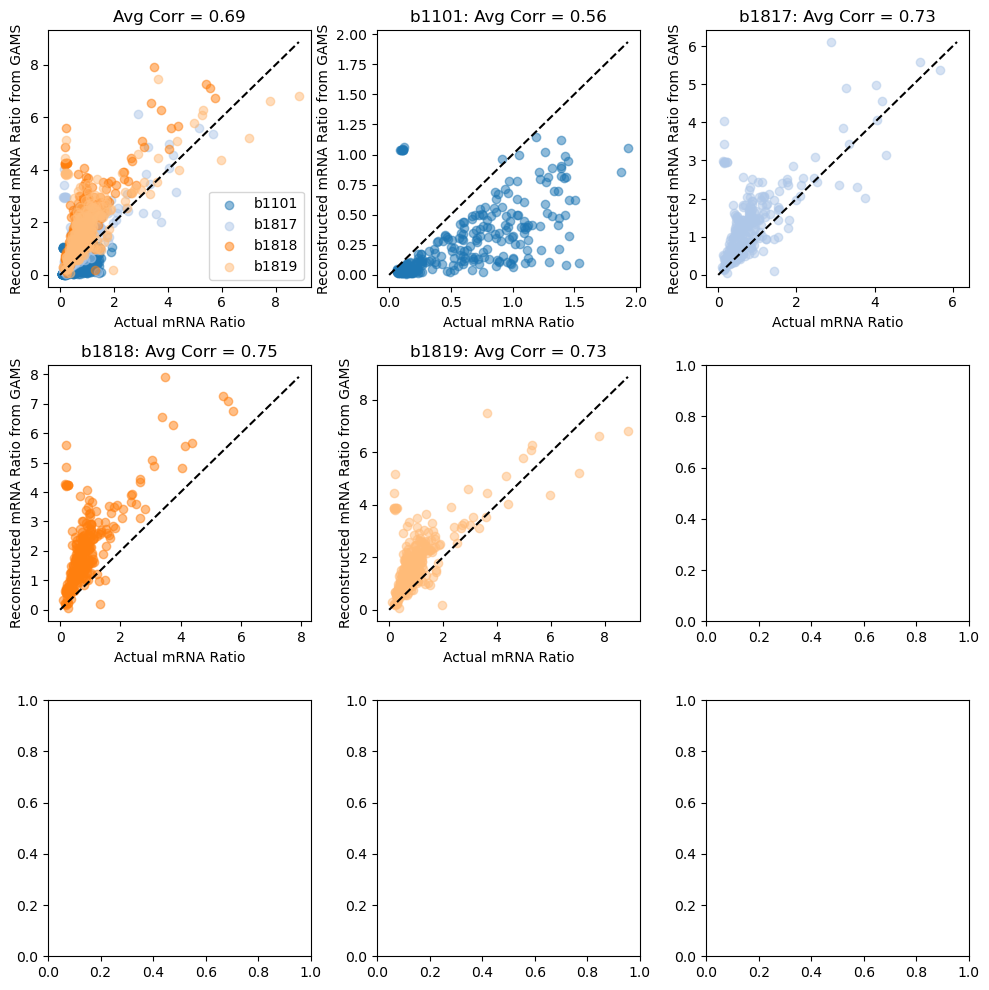

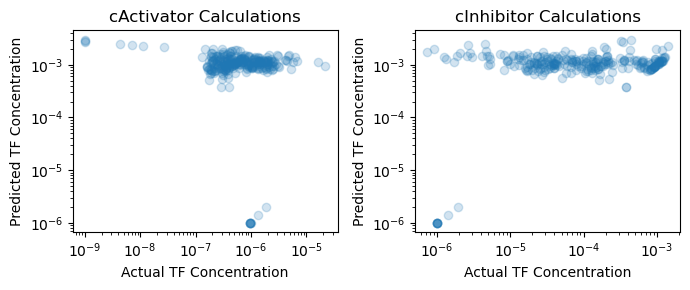

In [18]:
# read GAMs
calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs(flags)
if flags['sanity_plots']:
    
    # I need recreated cActivators and cInhibitors
    colors = iter(plt.cm.tab20.colors)
    shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    corrs = []
    max_mRNA = 0
    dims = int(np.sqrt(len(calc_cAct.columns)))+1
    fig, axs = plt.subplots(dims, dims, figsize = (10, 10))
    axs = axs.flatten()
    #plt.figure(figsize = (4, 4))
    g_ct = 1
    for gene in calc_cAct.columns:
        # load grid constants
        gene_grid_name = '../data/gene_grid_constants/'+gene+'.pkl'
        pickle_in = open(gene_grid_name, 'rb')
        grid = pickle.load(pickle_in)
        pickle_in.close()

        df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
        ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)

        recon_mRNA = []
        for cAct, cInh in zip(calc_cAct[gene].loc[shared], calc_cInh[gene].loc[shared]):
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid['KdRNAPCrp']))

        actual_mRNA = ratios_df.loc[shared]['actual_mRNA_ratio'].values.flatten()
        if max([max(actual_mRNA), max(recon_mRNA)]) > max_mRNA:
            max_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
        max_bby_mRNA = max([max(actual_mRNA), max(recon_mRNA)])

        corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
        corrs.append(corr[0][1])
        c = next(colors)
        axs[0].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].plot([0, max_bby_mRNA], [0, max_bby_mRNA], ls = '--', c = 'k')
        axs[g_ct].set_title(gene+': Avg Corr = {:.2f}'.format(corr[0][1]))
        axs[g_ct].set_xlabel('Actual mRNA Ratio')
        axs[g_ct].set_ylabel('Reconstructed mRNA Ratio from GAMS')
        g_ct += 1


    axs[0].plot([0, max_mRNA], [0, max_mRNA], ls = '--', c = 'k')
    axs[0].legend()
    axs[0].set_title('Avg Corr = {:.2f}'.format(np.mean(corrs)))
    axs[0].set_xlabel('Actual mRNA Ratio')
    axs[0].set_ylabel('Reconstructed mRNA Ratio from GAMS')
    plt.tight_layout()
    together_figs.append(fig)
    
    
    
    # TF conc values
    # histogram of TF_conc values
    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
    fig, axs = plt.subplots(1, 2, figsize = (7, 3))
    axs[0].scatter(TF_conc_df.T.loc[shared], scaled_df.loc['b3357'].T.loc[shared], alpha = 0.2)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Actual TF Concentration')
    axs[0].set_ylabel('Predicted TF Concentration')
    axs[0].set_title('cActivator Calculations')

    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
    axs[1].scatter(TF_conc_df.T.loc[shared], scaled_df.loc['b3357'].T.loc[shared], alpha = 0.2)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Actual TF Concentration')
    axs[1].set_ylabel('Predicted TF Concentration')
    axs[1].set_title('cInhibitor Calculations')
    plt.tight_layout()
    together_figs.append(fig)